In [1]:
"""Backend supported: pytorch, paddle, jax

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""

import deepxde as dde
import numpy as np
import time
import os
import argparse
import jax
import jax.numpy as jnp
from jaxopt import GaussNewton
from scipy.interpolate import RegularGridInterpolator
from functools import wraps
from typing import List, Tuple, Literal


Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [224]:
n_iter = 1000
log_every = 100 
available_time = 0
log_output_fields = {0: 'Ux', 1: 'Uy', 2: 'Sxx', 3: 'Syy', 4: 'Sxy'}
net_type = 'spinn'
bc_type = 'hard'
mlp = 'mlp'
n_DIC = 100
noise_magnitude = 0
lr = 0.001
u_0 = 1e-3
s0 = 1
loss_weights = [1,1,1,1,1,1,1,1,1e2,1e2]
# loss_weights = [1,1,1,1,1,1,1,1,1]

# loss_weights = [0,0,0,0,0,0,0,0,1,1]

stress_bc = False
net_type = 'spinn'
save_model = True
coord_normalization = True

In [249]:
#%%
if net_type == "spinn":
    dde.config.set_default_autodiff("forward")

x_max = 100.0
y_max = 100.0
notch_diameter = 50
material_law = "isotropic"  # "isotropic" or "orthotropic"

x_max_norm, y_max_norm = [1.0,1.0] if coord_normalization else [x_max, y_max]

# Material parameters (converted to N/mm^2)
if material_law == "isotropic":
    # isotropic plane‐stress
    E       = 52e3     # N/mm^2
    nu      = 0.3

    def constitutive_stress(eps_xx, eps_yy, eps_xy, mat_params=(E, nu)):
        # plane‐stress modified constants
        E, nu = mat_params
        # lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))
        # mu = E / (2 * (1 + nu))

        σ_xx = E/(1-nu**2)* (eps_xx + nu * eps_yy)
        σ_yy = E/(1-nu**2)* (eps_yy + nu * eps_xx)
        σ_xy = E/(1+nu) * eps_xy   

        return σ_xx, σ_yy, σ_xy

elif material_law == "orthotropic":
    # orthotropic plane‐stress
    Q11, Q22, Q12, Q66 = 41e3, 10.3e3, 3.1e3, 4e3   # N/mm^2

    def constitutive_stress(eps_xx, eps_yy, eps_xy):
        # plane‐stress modified constants
        σ_xx = Q11*eps_xx + Q12*eps_yy
        σ_yy = Q12*eps_xx + Q22*eps_yy
        σ_xy = 2*Q66*eps_xy
        return σ_xx, σ_yy, σ_xy
    

# Load
pstress = 50.0
# uy_top = pstress * x_max / E
uy_top = pstress * x_max / E  if material_law == 'isotropic' else pstress* x_max / Q22
print(f"Uy top: {uy_top:.3e} mm")
sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack

# Load geometry mapping
nx=60
ny=88
dir_path = r"."
Xp = np.loadtxt(os.path.join(dir_path, f"deep_notched_{nx}x{ny}.txt"))

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

@dde.utils.list_handler
def transform_coords(x):
    """
    For SPINN, if the input x is provided as a list of 1D arrays (e.g., [X_coords, Y_coords]),
    this function creates a 2D meshgrid and stacks the results into a 2D coordinate array.
    """
    x_mesh = [x_.ravel() for x_ in jnp.meshgrid(jnp.atleast_1d(x[0].squeeze()), jnp.atleast_1d(x[1].squeeze()), indexing="ij")]
    return dde.backend.stack(x_mesh, axis=-1)

def coordMap(x, X_map = X_map_points, Y_map = Y_map_points, x_max = x_max, y_max=y_max, padding=1e-6):
    x_pos = x[0] / x_max * (X_map.shape[0]-1) * (1-2*padding) + padding
    y_pos = x[1] / y_max * (Y_map.shape[1]-1) * (1-2*padding) + padding
    xm = jax.scipy.ndimage.map_coordinates(X_map,
           [x_pos, y_pos], order=1, mode='nearest')
    ym = jax.scipy.ndimage.map_coordinates(Y_map,
           [x_pos, y_pos], order=1, mode='nearest')
    return jnp.stack([xm, ym])

def F(x, phys_xy, X_map, Y_map, x_max, y_max, padding):
    return coordMap(x, X_map, Y_map, x_max, y_max, padding) - phys_xy

@jax.jit
def inv_coord_map(phys_xy, X_map = X_map_points, Y_map = Y_map_points, x_max = x_max, y_max=y_max, padding=1e-6):
    # initial guess at the center
    init_guess = jnp.array([0.5 * x_max, 0.5 * y_max])
    solver = GaussNewton(residual_fun=F,
                            tol=1e-6,
                            maxiter=25,
                            implicit_diff=True)
    sol = solver.run(
        init_params=init_guess,
        phys_xy=phys_xy,
        X_map=X_map,
        Y_map=Y_map,
        x_max=x_max,
        y_max=y_max,
        padding=padding
    ).params
    return sol


def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    J_inv = jnp.linalg.inv(J)
    return tens @ J_inv

def calcNormal(x):
    n = jnp.array([-1, 0])
    n_mapped = tensMap(n, x)
    return n_mapped/jnp.linalg.norm(n_mapped)
    

# Load solution
n_mesh_x = 100
n_mesh_y = 100

solution_name = f"{material_law}_{n_mesh_x}x{n_mesh_y}{'_S_bc' if stress_bc else ''}.dat"
data = np.loadtxt(os.path.join(dir_path, f"fem/{solution_name}"))
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.linspace(0, x_max, n_mesh_x)
y_grid = np.linspace(0, y_max, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

# def list_handler(func):
#     @wraps(func)
#     def wrapper(*args, **kwargs):
#         inputs = args[-1]

#         def apply_and_concat(item):
#             if isinstance(item, (list, tuple)) and all(isinstance(subitem, (list, tuple)) for subitem in item):
#                 return jnp.concat([apply_and_concat(subitem) for subitem in item], axis=0)
#             return func(*args[:-1], item, **kwargs)

#         return apply_and_concat(inputs)

#     return wrapper

# @list_handler
def solution_fn(x):
    if net_type == "spinn" and isinstance(x, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(x[0].squeeze()), 
            jnp.atleast_1d(x[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    # x = jax.vmap(coordMap)(x)
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

# geom = dde.geometry.Rectangle([0, 0], [x_max, y_max])
notch_dist = (y_max - notch_diameter) / 2
n_pde = 100
x_all = np.linspace(0, x_max, n_pde).reshape(-1, 1)
y_all = np.linspace(0, y_max, n_pde).reshape(-1, 1)
x_notch = np.stack((np.linspace(0, 0.2*x_max, int(n_pde/2)),
                    np.linspace(y_max - 0.2*x_max, y_max, int(n_pde/2))), axis=0).reshape(-1, 1)
y_notch = np.linspace(notch_dist, y_max - notch_dist, n_pde).reshape(-1, 1)

geom = dde.geometry.ListPointCloud([[x_all, y_all], 
                                    [x_notch, y_notch]])

def bc_factor(
    x1: jnp.ndarray,
    x2: jnp.ndarray,
    segments: List[Tuple[Tuple[float,float], Tuple[float,float]]],
    smoothness: Literal["C0", "C0+"] = "C0",
) -> jnp.ndarray:
    """
    x1, x2 : (n,) arrays of coordinates
    segments: list of ((xA,yA),(xB,yB))
    smoothness: "C0" = min distance, "C0+" = product of distances
    returns: (n,1) array
    """
    # helper: distance from (x1,x2) to segment A→B
    def _dist(A, B):
        xA, yA = A; xB, yB = B
        vx, vy = xB - xA, yB - yA
        # vector A→P
        px = x1 - xA
        py = x2 - yA
        t = jnp.clip((px*vx + py*vy) / (vx*vx + vy*vy), 0.0, 1.0)
        qx = xA + t*vx
        qy = yA + t*vy
        return jnp.hypot(x1 - qx, x2 - qy)[:, None]

    # build (n, m) matrix of distances
    D = jnp.hstack([ _dist(A, B) for A, B in segments ])

    raw = jnp.min(D, axis=1, keepdims=True)    if smoothness=="C0" else jnp.prod(D, axis=1, keepdims=True)
    M = raw.max()
    M = jnp.where(M > 0, M, 1.0)    # avoid dividing by 0
    return (raw / M).flatten()

contact_eps = 0.1 * x_max
contact_eps = 0

segs_Sxx = [
    ((0.0, contact_eps), (0.0, y_max - contact_eps)), # left
    ((x_max, contact_eps), (x_max, y_max - contact_eps)), # right
]

segs_Sxy = [
    ((0.0, contact_eps), (0.0, y_max - contact_eps)), # left
    ((x_max, contact_eps), (x_max, y_max - contact_eps)), # right
]

def HardBC(x, f, x_max_norm=x_max_norm, y_max_norm=y_max_norm):
    if net_type == "spinn" and isinstance(x, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(x[0].squeeze()), 
            jnp.atleast_1d(x[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    x_mapped = jax.vmap(coordMap)(x*x_max/x_max_norm)

    Ux = f[:, 0] * x[:, 1] / y_max_norm * (y_max_norm - x[:, 1]) / y_max_norm * u_0
    Uy = f[:, 1] * x[:, 1] / y_max_norm * (y_max_norm - x[:, 1]) / y_max_norm * u_0 + uy_top * (x[:, 1] / y_max_norm)

    Sxx = f[:, 2] * bc_factor(x_mapped[:, 0], x_mapped[:, 1], segs_Sxx, "C0+") * s0
    Syy = f[:, 3] * s0#* (y_max - x[:, 1]) / x_max + pstress
    Sxy = f[:, 4] * bc_factor(x_mapped[:, 0], x_mapped[:, 1], segs_Sxx, "C0+") * s0

    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)


def pde(x, f):
    # x_mesh = jnp.meshgrid(x[:,0].ravel(), x[:,0].ravel(), indexing='ij')
    x = transform_coords(x)
    # x_phys = jax.vmap(coordMap)(x)

    J_nn = jax.vmap(jax.jacfwd(f[1]))(x)
    J_comp2phys = jax.vmap(jax.jacfwd(coordMap))(x)
    J_phys2comp = jnp.linalg.inv(J_comp2phys)

    J = jnp.einsum("ijk,ikl->ijl", J_nn, J_phys2comp)

    E_xx = J[:, 0, 0]
    E_yy = J[:, 1, 1]
    E_xy = 0.5 * (J[:, 0, 1] + J[:, 1, 0])
    # E_xx = dde.grad.jacobian(f, x, i=0, j=0)[0] 
    # E_yy = dde.grad.jacobian(f, x, i=1, j=1)[0]
    # E_xy = 0.5 * (dde.grad.jacobian(f, x, i=0, j=1)[0] + dde.grad.jacobian(f, x, i=1, j=0)[0])

    S_xx, S_yy, S_xy = constitutive_stress(E_xx, E_yy, E_xy)

    Sxx_x = J[:, 2, 0]
    Syy_y = J[:, 3, 1]
    Sxy_x = J[:, 4, 0]
    Sxy_y = J[:, 4, 1]

    # Sxx_x = dde.grad.jacobian(f, x, i=2, j=0)[0]
    # Syy_y = dde.grad.jacobian(f, x, i=3, j=1)[0]
    # Sxy_x = dde.grad.jacobian(f, x, i=4, j=0)[0]
    # Sxy_y = dde.grad.jacobian(f, x, i=4, j=1)[0]

    momentum_x = Sxx_x + Sxy_y 
    momentum_y = Sxy_x + Syy_y 

    # if dde.backend.backend_name == "jax":
    #     f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[0][:, 2]
    stress_y = S_yy - f[0][:, 3]
    stress_xy = S_xy - f[0][:, 4]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

# Integral stress BC
n_integral = 100
x_integral = np.linspace(0, x_max, n_integral).reshape(-1, 1)
y_integral = np.linspace(0, y_max, n_integral).reshape(-1, 1)
X_integral = [x_integral, y_integral]

S_yy_fem = solution_fn(X_integral)[:, 3:4].reshape(n_integral, n_integral)
x_integral_mesh = transform_coords(X_integral)
x_integral_mesh = jax.vmap(coordMap)(x_integral_mesh)[:,0].reshape(n_integral, n_integral)
S_yy_integral_fem = np.trapezoid(S_yy_fem, x_integral_mesh, axis=0)
p_top = S_yy_integral_fem.mean()

def integral_stress(inputs, outputs, X):
    if net_type == "spinn" and isinstance(inputs, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(inputs[0].squeeze()), 
            jnp.atleast_1d(inputs[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    x_mesh = jax.vmap(coordMap)(x)[:,0].reshape((inputs[0].shape[0], inputs[0].shape[0]))

    Syy = outputs[0][:, 3:4].reshape(x_mesh.shape)
    return jnp.trapezoid(Syy, x_mesh, axis=0)

Integral_BC = dde.PointSetOperatorBC(X_integral, p_top, integral_stress)

# Free surface BC
n_free = 400
y_free = jnp.linspace(0, x_max, n_free)
X_free = jnp.stack((jnp.zeros(n_free), y_free), axis=1)
sharp_corner_tol = 0.1

mask = (notch_dist < jax.vmap(coordMap)(X_free)[:, 1]) & (jax.vmap(coordMap)(X_free)[:, 1] < y_max- notch_dist)
X_free = X_free[mask] #keep bottom left corner: 99 points

X_free_left = [jnp.array([0]).reshape(-1, 1), X_free[:, 1].reshape(-1, 1)]
X_free_right = [jnp.array([x_max]).reshape(-1, 1), X_free[:, 1].reshape(-1, 1)]

def free_surface_balance(inputs, outputs, X):
    if net_type == "spinn" and isinstance(inputs, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(inputs[0].squeeze()), 
            jnp.atleast_1d(inputs[1].squeeze()), 
            indexing="ij"
        )]
        inputs = stack(x_mesh, axis=-1)
    outputs = outputs[0]
    normal = jax.vmap(calcNormal)(inputs)
    normal_x, normal_y = normal[:,0], normal[:,1]
    Sxx = outputs[:, 2]
    Syy = outputs[:, 3]
    Sxy = outputs[:, 4]

    balance_x = Sxx * normal_x + Sxy * normal_y
    balance_y = Sxy * normal_x + Syy * normal_y
    return jnp.abs(balance_x) + jnp.abs(balance_y)

#TODO adapt to deep notched geometry
Free_BC_left = dde.PointSetOperatorBC(X_free_left, 0, free_surface_balance)
Free_BC_right = dde.PointSetOperatorBC(X_free_right, 0, free_surface_balance)

bcs = [Free_BC_left, Free_BC_right, Integral_BC] 
# bcs = [Free_BC_right, Integral_BC] 

num_boundary = 0
X_DIC_input = [np.linspace(0, x_max, n_DIC).reshape(-1, 1)] * 2

DIC_data = solution_fn(X_DIC_input)[:, :2]
DIC_data += np.random.normal(0, noise_magnitude, DIC_data.shape)

DIC_norms = np.mean(np.abs(DIC_data), axis=0) # to normalize the loss
measure_Ux = dde.PointSetOperatorBC(X_DIC_input, DIC_data[:, 0:1]/DIC_norms[0],
                                        lambda x, f, x_np: f[0][:, 0:1]/DIC_norms[0])
measure_Uy = dde.PointSetOperatorBC(X_DIC_input, DIC_data[:, 1:2]/DIC_norms[1],
                                        lambda x, f, x_np: f[0][:, 1:2]/DIC_norms[1])
bcs += [measure_Ux, measure_Uy]

def get_num_params(net, input_shape=None):
    if dde.backend.backend_name == "pytorch":
        return sum(p.numel() for p in net.parameters())
    elif dde.backend.backend_name == "paddle":
        return sum(p.numpy().size for p in net.parameters())
    elif dde.backend.backend_name == "jax":
        if input_shape is None:
            raise ValueError("input_shape must be provided for jax backend")
        import jax
        import jax.numpy as jnp

        rng = jax.random.PRNGKey(0)
        return sum(
            p.size for p in jax.tree.leaves(net.init(rng, jnp.ones(input_shape)))
        )


activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
h_plot = 0.02
if net_type == "spinn":
    layers = [2, 32, 32, 32, 5]
    #TODO mixNN
    net = dde.nn.SPINN(layers, activation, initializer, mlp)
    num_point = 100**2
    total_points = num_point**2 + num_boundary**2
    num_params = get_num_params(net, input_shape=layers[0])
    x_plot = np.linspace(0,x_max,100)
    y_plot = np.linspace(0,y_max,100)
    X_plot = np.stack((x_plot, y_plot), axis=1)

else:
    layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
    net = dde.nn.PFNN(layers, activation, initializer)
    num_point = 500
    total_points = num_point + num_boundary
    num_params = get_num_params(net, input_shape=layers[0])
    X_mesh = np.meshgrid(
        np.linspace(0, x_max, int(x_max/h_plot)),
        np.linspace(0, y_max, int(y_max/h_plot)),
        indexing="ij",
    )
    X_plot = np.stack((X_mesh[0].ravel(), X_mesh[1].ravel()), axis=1)

num_test = 10000

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_point,
    num_boundary=num_boundary,
    solution=solution_fn,
    num_test=num_test,
    is_SPINN=net_type == "spinn",
)

def input_scaling(x):
    """
    Scale the input coordinates to the range [0, 1].
    """
    if isinstance(x, list):
        return [x_el / x_max for x_el in x]
    else:
        return x / x_max

if coord_normalization:
    net.apply_feature_transform(input_scaling)
if bc_type == "hard":
    net.apply_output_transform(HardBC)

model = dde.Model(data, net)
model.compile(optimizer, lr=lr, metrics=["l2 relative error"], loss_weights=loss_weights)


# n_iter = 1000
# log_every = 10
# save_model_path = "/home/dbey/SPIQ/deep_notched/test_model"
# losshistory, train_state = model.train(
#     iterations=n_iter, callbacks=callbacks, display_every=log_every
# )


Set the default automatic differentiation to forward mode.
Uy top: 9.615e-02 mm
Compiling model...
'compile' took 0.108807 s



In [250]:
def adaptive_sampling_grid(domain, n, loss_fun, k=1, c=1, n_rand=200, 
                           use_probabilistic=True, random_state=None):
    """
    Choose n x-coordinates and n y-coordinates so that the n×n grid they
    generate (via Cartesian product) lies in the regions of highest loss.

    Parameters
    ----------
    domain : array_like shape (2, 2)
        [[xmin, xmax], [ymin, ymax]]
    n : int
        Number of distinct x points (and y points) to return.
        The grid will therefore contain n² points in total.
    loss_fun : callable
        loss_fun([X, Y]) must accept two 1-D arrays of equal length and
        return a 1-D loss array of the same length.
    k, c : float, optional
        Exponent and offset controlling how aggressively we focus on high-loss
        regions (same spirit as your original code).
    n_rand : int, optional
        Number of random coordinates in each axis used to build the trial grid.
    use_probabilistic : bool, optional
        If True, sample with probabilities proportional to row/column scores;
        if False, take the n rows and n columns with the highest scores
        deterministically.
    random_state : int or np.random.Generator, optional
        For reproducibility.
    """
    rng = np.random.default_rng(random_state)

    # ------------------------------------------------------------------
    # 1) Build a random trial grid of shape (n_rand, n_rand)
    # ------------------------------------------------------------------
    x_trial = rng.uniform(domain[0, 0], domain[0, 1], n_rand).reshape(-1, 1)  
    y_trial = rng.uniform(domain[1, 0], domain[1, 1], n_rand).reshape(-1, 1)

    Xg, Yg = np.meshgrid(x_trial, y_trial, indexing='ij')   # shape (n_rand, n_rand)

    # ------------------------------------------------------------------
    # 2) Evaluate the loss on every grid point
    # ------------------------------------------------------------------
    loss_flat = loss_fun([x_trial, y_trial])
    loss = loss_flat.reshape(n_rand, n_rand)

    # ------------------------------------------------------------------
    # 3) Convert the loss into row / column scores
    # ------------------------------------------------------------------
    weight = (loss ** k) / np.mean(loss ** k) + c    # emphasise large losses
    row_scores = weight.sum(axis=1)                  # shape (n_rand,)
    col_scores = weight.sum(axis=0)                  # shape (n_rand,)

    if use_probabilistic:
        # ---- probabilistic selection, like in your first version --------
        row_p = row_scores / row_scores.sum()
        col_p = col_scores / col_scores.sum()

        row_idx = rng.choice(n_rand, size=n, replace=False, p=row_p)
        col_idx = rng.choice(n_rand, size=n, replace=False, p=col_p)
    else:
        # ---- deterministic: take the top-n rows / columns --------------
        row_idx = np.argsort(-row_scores)[:n]
        col_idx = np.argsort(-col_scores)[:n]

    # ------------------------------------------------------------------
    # 4) Return the 1-D coordinate arrays
    # ------------------------------------------------------------------
    x_sample = np.sort(x_trial[row_idx])   # sort for nicer grids / plots
    y_sample = np.sort(y_trial[col_idx])

    return x_sample, y_sample

In [251]:
from jax.flatten_util import ravel_pytree

bc_anchors = [X_free_left, X_free_right, X_integral, X_DIC_input, X_DIC_input]
# bc_anchors = [X_free_right, X_integral, X_DIC_input, X_DIC_input]

pde_anchors = [[x_all, y_all]]

all_anchors = bc_anchors + pde_anchors

def loss_function(params,comp=0,inputs=all_anchors):
    return model.outputs_losses_train(params, inputs, None)[1][comp]

n_loss = len(loss_weights)
lr = 0.01
optimizer = 'adam'

def calc_loss_weights(model):
    loss_grads = [1]*n_loss

    for i in range(n_loss):
        grad_fn = jax.grad(lambda params,comp=i: loss_function(params,comp))
        grads = grad_fn(model.params)[0]
        flattened_grad = ravel_pytree(list(grads.values())[0])[0]
        loss_grads[i] = jnp.linalg.norm(flattened_grad)

    loss_grads = jnp.array(loss_grads)
    loss_weights_grads = jnp.sqrt(jnp.sum(loss_grads)/loss_grads) # Caution: ad-hoc sqrt
    return loss_weights_grads, loss_grads

In [266]:
n_iter = 20000
log_every = 1000
lr = 0.001

# save_model_path = "/home/dbey/SPIQ/deep_notched/test_model"
# model.compile(optimizer, lr=0.001, metrics=["l2 relative error"], loss_weights=loss_weights)
losshistory, train_state = model.train(
    iterations=n_iter, display_every=log_every
)
# model.compile(optimizer, lr=0.0001, metrics=["l2 relative error"], loss_weights=loss_weights)
# losshistory, train_state = model.train(
#     iterations=100000, display_every=10000
# )


Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric   
130000    [4.91e+00, 9.26e+00, 3.04e+01, 2.42e+01, 3.96e+01, 2.40e+01, 2.29e+01, 2.75e+02, 7.13e+00, 3.83e-01]    [6.40e+00, 1.21e+01, 6.39e+01, 3.37e+01, 2.77e+01, 2.40e+01, 2.28e+01, 2.75e+02, 7.02e+00, 3.76e-01]    [7.27e-02]    
131000    [4.63e+00, 9.00e+00, 9.13e+00, 7.63e+00, 3.02e+01, 2.13e+01, 8.70e+00, 6.67e+00, 2.81e+00, 2.81e-01]    [5.77e+00, 1.23e+01, 2.21e+01, 1.12e+01, 1.67e+01, 2.14e+01, 8.71e+00, 5.85e+00, 2.81e+00, 2.83e-01]    [6.90e-02]    
132000    [4.57e+00, 8.65e+00, 8.98e+00, 7.80e+00, 2.98e+01, 2.12e+01, 8.61e+00, 1.91e+00, 2.72e+00, 2.56e-01]    [5.70e+00, 1.19e+01, 2.11e+01, 1.19e+01, 1.67e+01, 2.12e+01, 8.61e+00, 1.86e+00, 2.80e+00, 2.63e-01]    [6.79e-02]    
133000    [4.51e+00, 8.33e+00, 1.00e+01, 9.78e+00

In [256]:

# anchors = [[x_all, y_all]]
# pde_anchors = [[x_all, y_all], [x_notch, y_notch]]

domain = np.array([[0, x_max], [0, y_max]])

def PDE_loss(X):
    pde_loss_val = model.predict([X[0], X[1]], operator=pde)
    return np.sum(np.abs(pde_loss_val), axis=0)

n_iter =10000
log_every = 1000
for i in range(5):
    if i > 0:
        x_sample, y_sample = adaptive_sampling_grid(domain,
                                    n=10,
                                    loss_fun=PDE_loss,
                                    k=2, c=1,
                                    n_rand=200,
                                    use_probabilistic=False)
        pde_anchors += [[x_sample, y_sample]]
        data.replace_with_anchors(pde_anchors)

        loss_weights_grads, loss_grads = calc_loss_weights(model)
        new_loss_weights = [w * g for w, g in zip(loss_weights, loss_weights_grads)]
        
        model.compile(optimizer, lr=lr, metrics=["l2 relative error"],
                    loss_weights=new_loss_weights)

        

    losshistory, train_state = model.train(
        iterations=n_iter, display_every=log_every
    )



Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric   
20000     [5.23e+00, 7.50e+00, 1.31e+01, 1.67e+02, 2.15e+01, 4.61e+00, 7.27e+01, 2.36e+02, 6.45e+00, 1.05e+00]    [5.23e+00, 7.50e+00, 1.31e+01, 1.67e+02, 2.15e+01, 4.61e+00, 7.27e+01, 2.36e+02, 6.45e+00, 1.05e+00]    [4.59e-01]    


21000     [5.23e+00, 7.26e+00, 1.22e+01, 1.60e+02, 2.18e+01, 4.25e+00, 7.02e+01, 3.15e+01, 6.39e+00, 1.07e+00]    [5.23e+00, 7.26e+00, 1.22e+01, 1.60e+02, 2.18e+01, 4.25e+00, 7.02e+01, 3.15e+01, 6.39e+00, 1.07e+00]    [4.58e-01]    
22000     [5.27e+00, 7.08e+00, 1.21e+01, 1.57e+02, 2.15e+01, 4.51e+00, 6.41e+01, 3.09e+01, 6.39e+00, 1.07e+00]    [5.27e+00, 7.08e+00, 1.21e+01, 1.57e+02, 2.15e+01, 4.51e+00, 6.41e+01, 3.09e+01, 6.39e+00, 1.07e+00]    [4.56e-01]    
23000     [5.23e+00, 6.99e+00, 1.24e+01, 1.52e+02, 2.14e+01, 4.71e+00, 6.02e+01, 2.87e+01, 6.22e+00, 1.07e+00]    [5.23e+00, 6.99e+00, 1.24e+01, 1.52e+02, 2.14e+01, 4.71e+00, 6.02e+01, 2.87e+01, 6.22e+00, 1.07e+00]    [4.53e-01]    
24000     [5.12e+00, 7.02e+00, 1.16e+01, 1.49e+02, 2.08e+01, 5.38e+00, 5.55e+01, 4.20e+01, 6.24e+00, 1.06e+00]    [5.12e+00, 7.02e+00, 1.16e+01, 1.49e+02, 2.08e+01, 5.38e+00, 5.55e+01, 4.20e+01, 6.24e+00, 1.06e+00]    [4.50e-01]    
25000     [5.14e+00, 7.01e+00, 1.21e+01, 1.46e+02, 2.03e+01, 5.50e+0

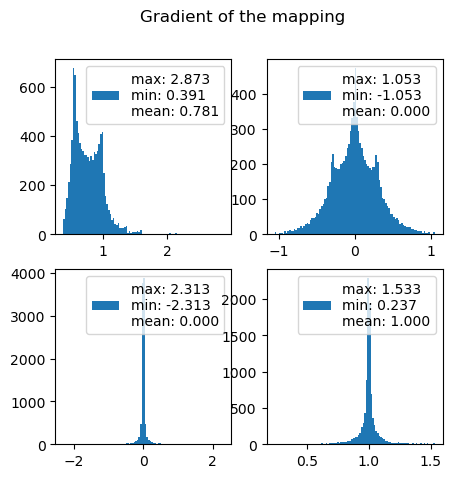

In [211]:
import matplotlib.pyplot as plt

R=50
L=100.0
ngrid=100

x_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
y_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
# X_input_bcs = np.stack((x_bcs, y_bcs), axis=1)
X_input_bcs = [[x_bcs, y_bcs]]
F_bcs = model.predict(X_input_bcs)

x_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
y_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
# X_input = np.stack((x_center, y_center), axis=1)
Xgrid_sol, Ygrid_sol = np.meshgrid(x_center, y_center, indexing="ij")
grad_vmap = jax.vmap(jax.jacfwd(coordMap))(np.stack((Xgrid_sol.ravel(), Ygrid_sol.ravel()), axis=1))

fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for i in range(4):
    ax[i//2, i%2].hist(grad_vmap[:,i//2:i//2+1,i%2], bins=100, label=f"max: {np.max(grad_vmap[:,i//2:i//2+1,i%2]):.3f}\nmin: {np.min(grad_vmap[:,i//2:i//2+1,i%2]):.3f}\nmean: {np.mean(grad_vmap[:,i//2:i//2+1,i%2]):.3f}")
    ax[i//2, i%2].legend()
plt.suptitle("Gradient of the mapping")
plt.show()

# plt.hist(grad_vmap[:,0:1,0], bins=100)

In [267]:
import matplotlib.colors as colors
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt

R=50
L=100.0
ngrid=100

x_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
y_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
# X_input_bcs = np.stack((x_bcs, y_bcs), axis=1)
X_input_bcs = [[x_bcs, y_bcs]]
F_bcs = model.predict(X_input_bcs)

x_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
y_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
# X_input = np.stack((x_center, y_center), axis=1)
Xgrid_sol, Ygrid_sol = np.meshgrid(x_center, y_center, indexing="ij")
Xmesh_sol = jax.vmap(coordMap)(np.stack((Xgrid_sol.ravel(), Ygrid_sol.ravel()), axis=1))
Xmesh_sol, Ymesh_sol = Xmesh_sol[:,0].reshape(Xgrid_sol.shape), Xmesh_sol[:,1].reshape(Ygrid_sol.shape)

X_input = [[x_center, y_center]]
x_edge = np.linspace(0,L,ngrid)
y_edge = np.linspace(0,L,ngrid)

Xgrid, Ygrid = np.meshgrid(x_edge, y_edge, indexing="ij")
Xmesh = jax.vmap(coordMap)(np.stack((Xgrid.ravel(), Ygrid.ravel()), axis=1))
Xmesh, Ymesh = Xmesh[:,0].reshape(Xgrid.shape), Xmesh[:,1].reshape(Ygrid.shape)

F = model.predict(X_input)
Ux = F[:, 0:1].reshape(len(x_center), len(y_center))
Uy = F[:, 1].reshape(len(x_center), len(y_center))
Sxx = F[:, 2].reshape(len(x_center), len(y_center))
Syy = F[:, 3].reshape(len(x_center), len(y_center))
Sxy = F[:, 4].reshape(len(x_center), len(y_center))


cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = colors.ListedColormap(color_values)

def pcolor_plot(AX, X, Y, C, title,colormap=cmap,norm=None):

    # X, Y = compute_edges_from_nodes(X, Y)
    im = AX.pcolormesh(X, Y, C, cmap=colormap,shading='auto',norm=norm, edgecolors='none', linewidth=0.01)

    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# im = pcolor_plot(axs[0], Xmesh, Ymesh, Ux, "Ux")
# fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(axs[1], Xmesh, Ymesh, Uy, "Uy")
# fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))

# fig, axs = plt.subplots(1, 3, figsize=(24, 6))
# im = pcolor_plot(axs[0], Xmesh, Ymesh, Sxx, "Sxx")
# fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(axs[1], Xmesh, Ymesh, Syy, "Syy")
# fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(axs[2], Xmesh, Ymesh, Sxy, "Sxy")
# fig.colorbar(im, ax=axs[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))


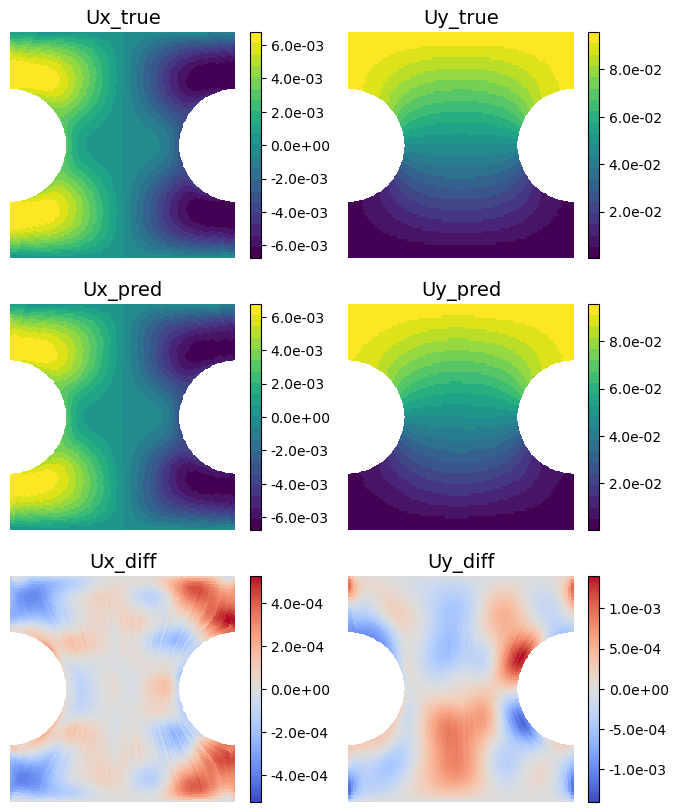

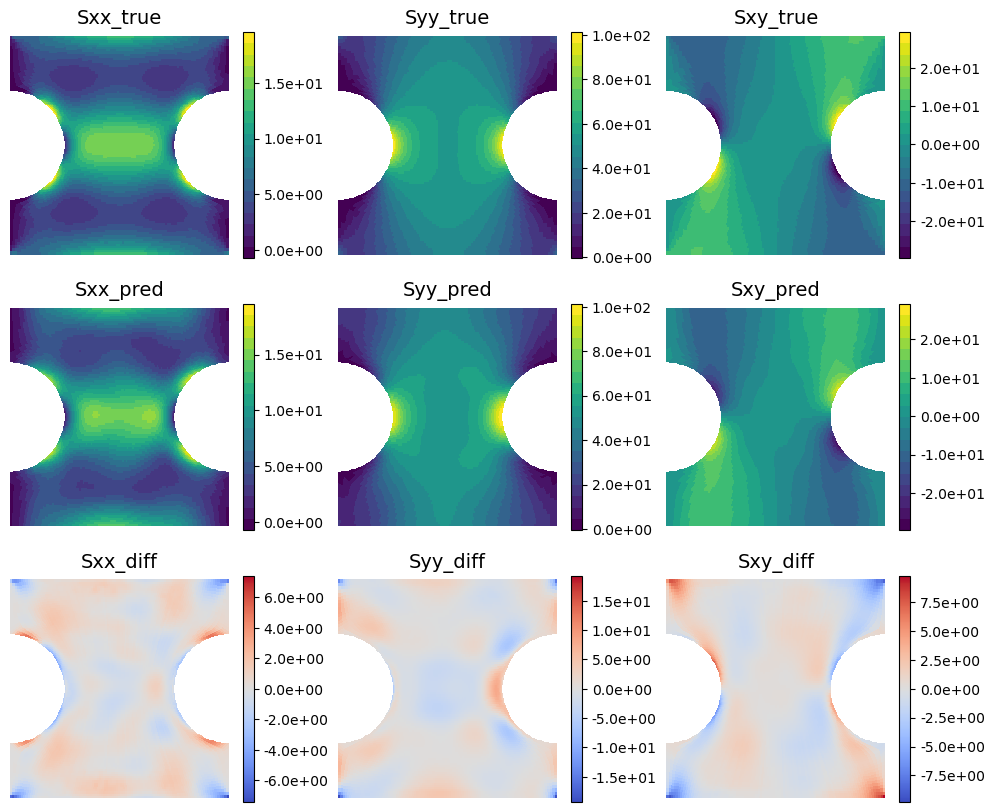

In [268]:
fields_bc_true = [solution_fn(np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1))))[:, i].reshape(Xgrid.shape) for i in range(5)]
fields_true = [solution_fn(np.hstack((Xgrid_sol.reshape(-1, 1), Ygrid_sol.reshape(-1, 1))))[:, i].reshape(Xgrid_sol.shape) for i in range(5)]

titles = ["Ux", "Uy", "Sxx", "Syy", "Sxy"]
fields = [Ux, Uy, Sxx, Syy, Sxy]
fig, axs = plt.subplots(3, 2, figsize=(8, 10))
for i, ax in enumerate(axs.T):
    im = pcolor_plot(ax[0], Xmesh, Ymesh, fields_true[i], titles[i]+"_true")
    fig.colorbar(im, ax=ax[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    norm = colors.Normalize(vmin=fields_true[i].min(), vmax=fields_true[i].max())
    im = pcolor_plot(ax[1], Xmesh, Ymesh, fields[i], titles[i]+"_pred",norm=norm)
    fig.colorbar(im, ax=ax[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    diff = fields[i] - fields_true[i]
    abs_diff = np.abs(diff)
    cmax = abs_diff.max() #if diff.max() > 0 else 0
    cmin = -abs_diff.max() #if diff.min() < 0 else 0
    norm = colors.Normalize(vmin=cmin, vmax=cmax)
    im = pcolor_plot(ax[2], Xmesh, Ymesh, diff, titles[i]+"_diff",colormap='coolwarm', norm=norm)
    fig.colorbar(im, ax=ax[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))


fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i, ax in enumerate(axs.T):
    im = pcolor_plot(ax[0], Xmesh, Ymesh, fields_true[i+2], titles[i+2]+"_true")
    fig.colorbar(im, ax=ax[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    norm = colors.Normalize(vmin=fields_true[i+2].min(), vmax=fields_true[i+2].max())
    im = pcolor_plot(ax[1], Xmesh, Ymesh, fields[i+2], titles[i+2]+"_pred",norm=norm)
    fig.colorbar(im, ax=ax[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    diff = fields[i+2] - fields_true[i+2]
    abs_diff = np.abs(diff)
    cmax = abs_diff.max() #if diff.max() > 0 else 0
    cmin = -abs_diff.max() #if diff.min() < 0 else 0
    norm = colors.Normalize(vmin=cmin, vmax=cmax)
    im = pcolor_plot(ax[2], Xmesh, Ymesh, diff, titles[i+2]+"_diff",colormap='coolwarm', norm=norm)
    fig.colorbar(im, ax=ax[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))


Number of sample sets: 1


IndexError: list index out of range

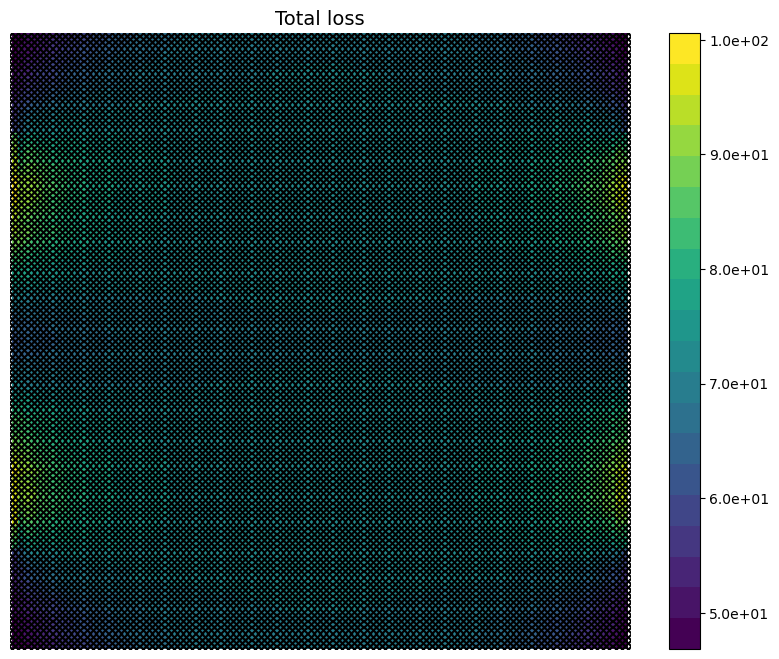

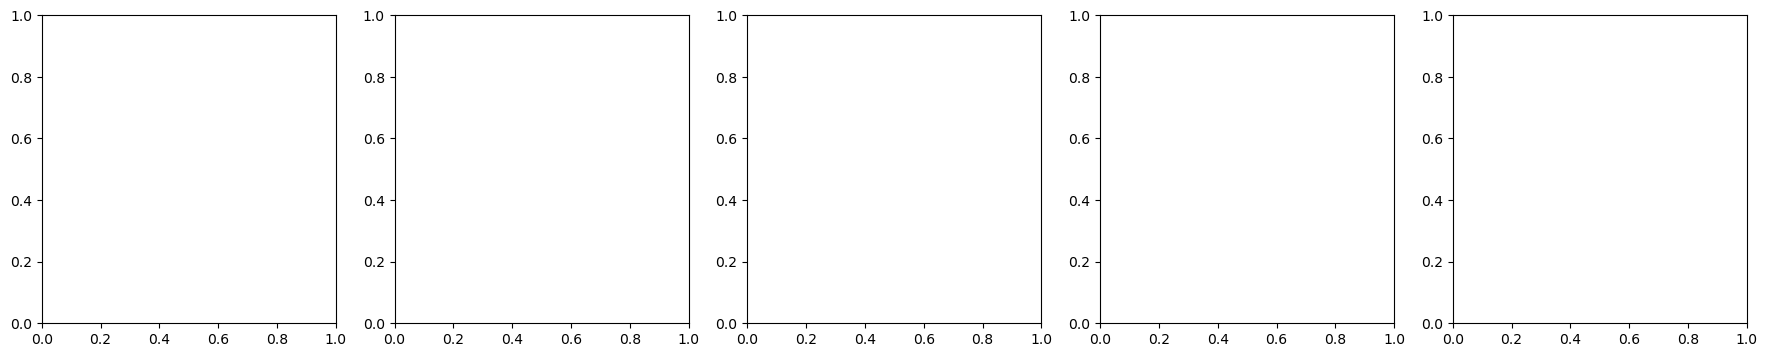

In [237]:
# def transform_coords(x):
#     """
#     For SPINN, if the input x is provided as a list of 1D arrays (e.g., [X_coords, Y_coords]),
#     this function creates a 2D meshgrid and stacks the results into a 2D coordinate array.
#     """
#     x_mesh = [x_.ravel() for x_ in jnp.meshgrid(jnp.atleast_1d(x[0].squeeze()), jnp.atleast_1d(x[1].squeeze()), indexing="ij")]
#     return dde.backend.stack(x_mesh, axis=-1)

#plot spatial repartition of the loss 
inputs_center = [[x_center, y_center]]
outputs_center = model.predict(inputs_center)
outputs_fun = lambda x: model.net.apply(model.net.params, x)
outputs = (outputs_center, outputs_fun)

pde_loss = pde(inputs_center, outputs)
subsample = 4
X_all_plot =  transform_coords([x_all[::subsample], y_all[::subsample]])
X_notch_plot =  transform_coords([x_notch[::subsample], y_notch[::subsample]])


phy_coord = 0
X_coords = Xmesh if phy_coord else Xgrid
Y_coords = Ymesh if phy_coord else Ygrid
if phy_coord:
    X_all_plot = jax.vmap(coordMap)(X_all_plot)
    X_notch_plot = jax.vmap(coordMap)(X_notch_plot)

# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# im = pcolor_plot(ax[0], X_coords, Y_coords, pde_loss[0].reshape(Xgrid_sol.shape), "PDE loss x")
# fig.colorbar(im, ax=ax[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(ax[1], X_coords, Y_coords, pde_loss[1].reshape(Xgrid_sol.shape), "PDE loss y")
# fig.colorbar(im, ax=ax[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# # for ax_ in ax:
# #     ax_.scatter(X_all_plot[:, 0], X_all_plot[:, 1], s=1, color="black")#, alpha=0.1)
# #     ax_.scatter(X_notch_plot[:, 0], X_notch_plot[:, 1], s=1, color="red")#, alpha=0.5)

# fig, ax = plt.subplots(1, 3, figsize=(15, 4))
# im = pcolor_plot(ax[0], X_coords, Y_coords, pde_loss[2].reshape(Xgrid_sol.shape), "Stress loss Sxx")
# fig.colorbar(im, ax=ax[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(ax[1], X_coords, Y_coords, pde_loss[3].reshape(Xgrid_sol.shape), "Stress loss Syy")
# fig.colorbar(im, ax=ax[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(ax[2], X_coords, Y_coords, pde_loss[4].reshape(Xgrid_sol.shape), "Stress loss Sxy")
# fig.colorbar(im, ax=ax[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))

fig, ax = plt.subplots(1,1, figsize=(10, 8))
im = pcolor_plot(ax, X_coords, Y_coords, np.sum(np.abs(pde_loss), axis=0).reshape(Xgrid_sol.shape), "Total loss")
fig.colorbar(im, ax=ax, format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
s_i = -1
X_sample_plot = transform_coords(pde_anchors[s_i])
ax.scatter(X_sample_plot[:, 0], X_sample_plot[:, 1], marker="x", color="black")#, alpha=0.1)
print(f"Number of sample sets: {len(pde_anchors)}")

fig, ax = plt.subplots(1, 5, figsize=(22, 4))
for i in range(5):
    X_sample_plot = transform_coords(pde_anchors[i+1])
    ax_i = ax.flatten()[i]
    ax_i.scatter(X_sample_plot[:, 0], X_sample_plot[:, 1], s=3, color="black")#, alpha=0.1)
    ax_i.set_title(f"Sample set {i+1}")
    ax_i.axis("equal")
    # ax_i.axis("off")


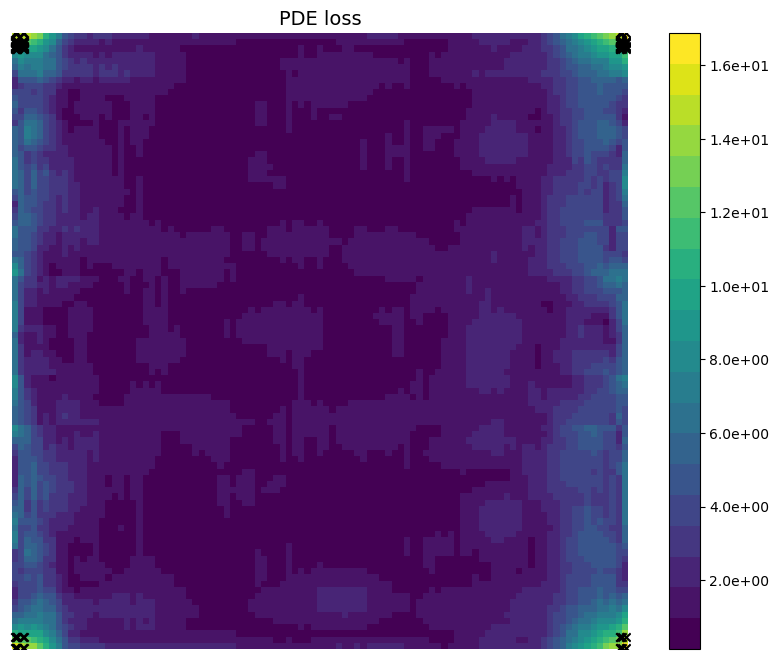

In [269]:
domain = np.array([[0, x_max], [0, y_max]])

# Test the adaptative sampling with a simple loss and different values of k and c
PDE_loss = lambda X: X[0] * (1 - X[0]) * X[1] * (1 - X[1])

def PDE_loss(X):
    pde_loss_val = model.predict([X[0], X[1]], operator=pde)
    return np.sum(np.abs(pde_loss_val), axis=0)

x_sample, y_sample = adaptive_sampling_grid(domain,
                                            n=10,
                                            loss_fun=PDE_loss,
                                            k=2, c=1,
                                            n_rand=200,
                                            use_probabilistic=False)

# -- build the full 25-point grid (your helper)
X_sample = transform_coords((x_sample, y_sample))

if phy_coord:
    X_sample = jax.vmap(coordMap)(X_sample)

# -- plot ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 8))
im = pcolor_plot(ax,X_coords,Y_coords,PDE_loss(inputs_center[0]).reshape(Xgrid_sol.shape), "PDE loss")
fig.colorbar(im, ax=ax, format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
ax.scatter(X_sample[:, 0], X_sample[:, 1], marker="x", color="black")

/tmp/ipykernel_2648/2891365039.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


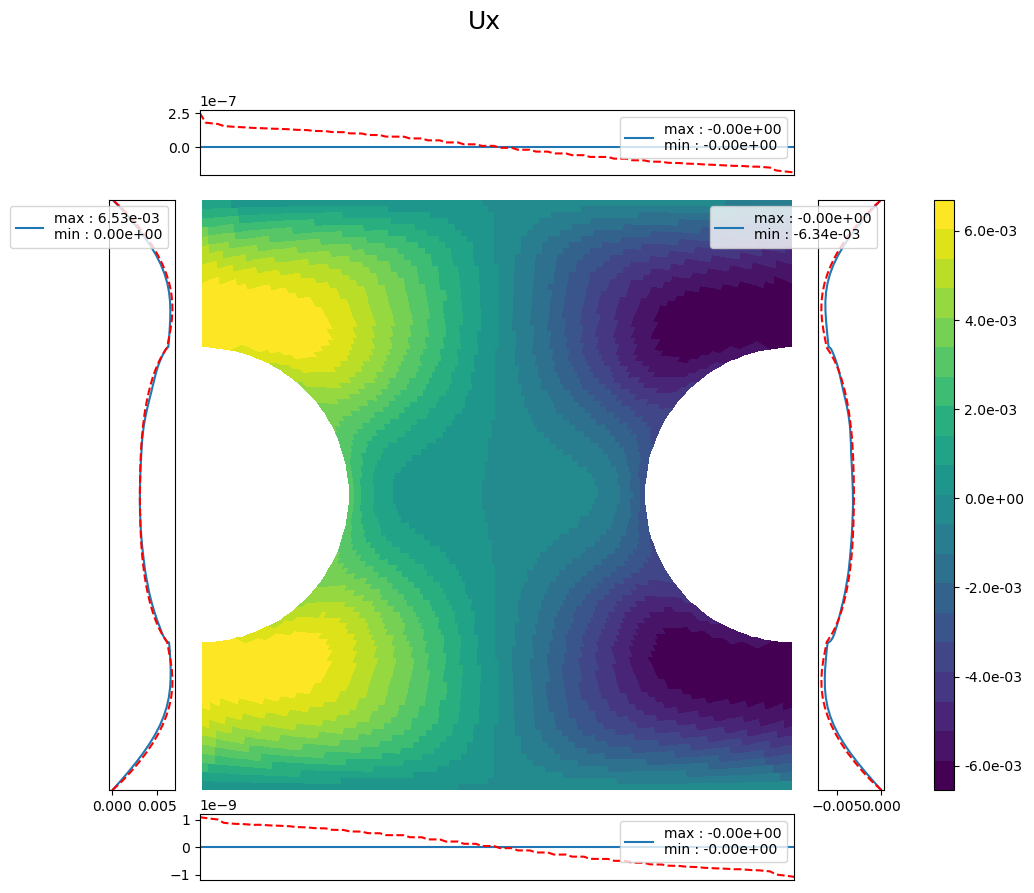

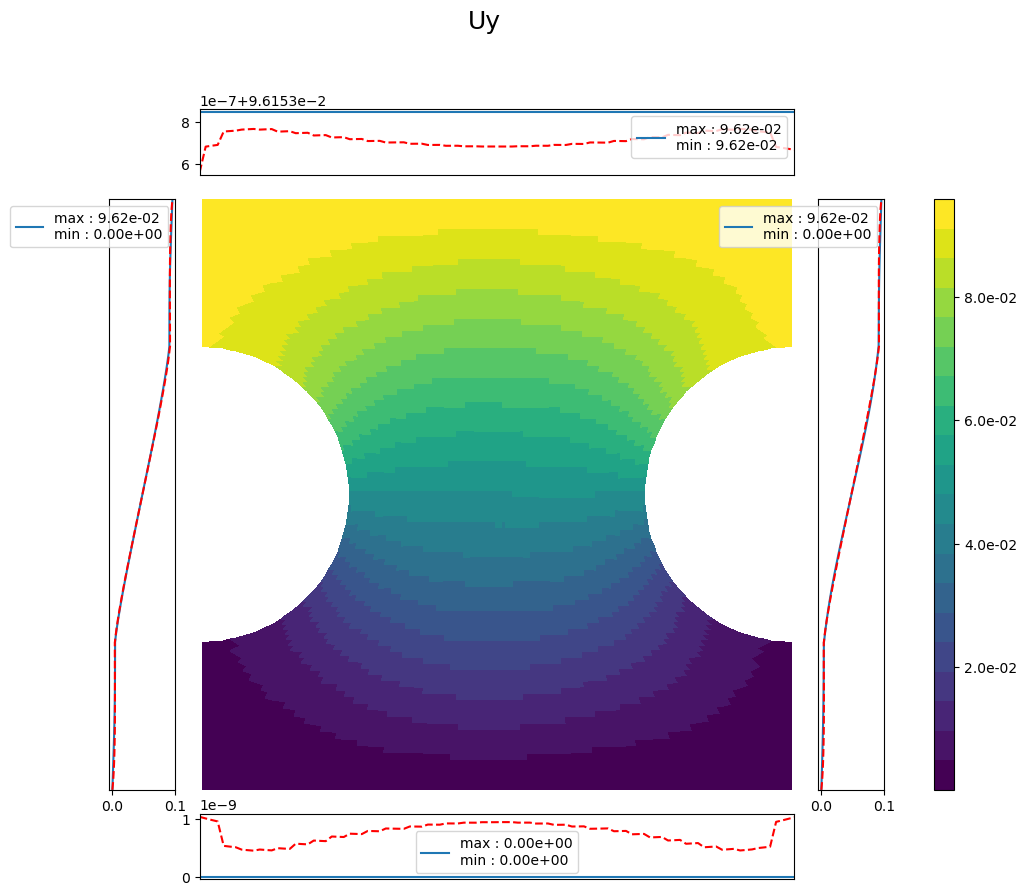

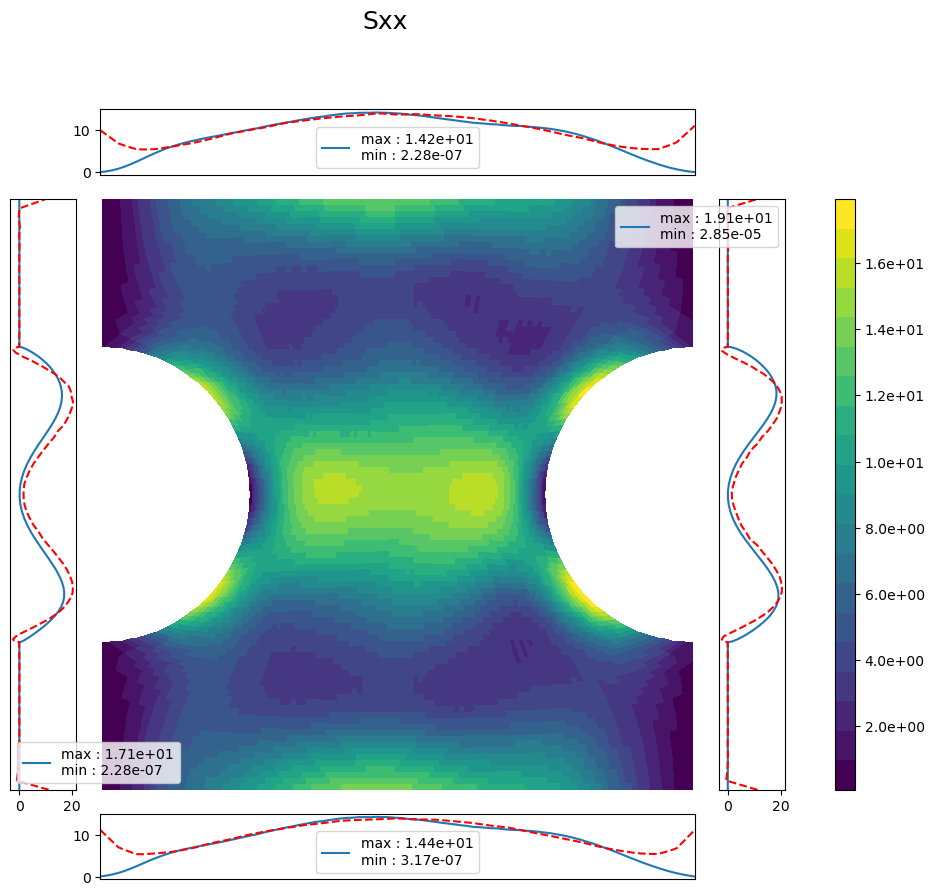

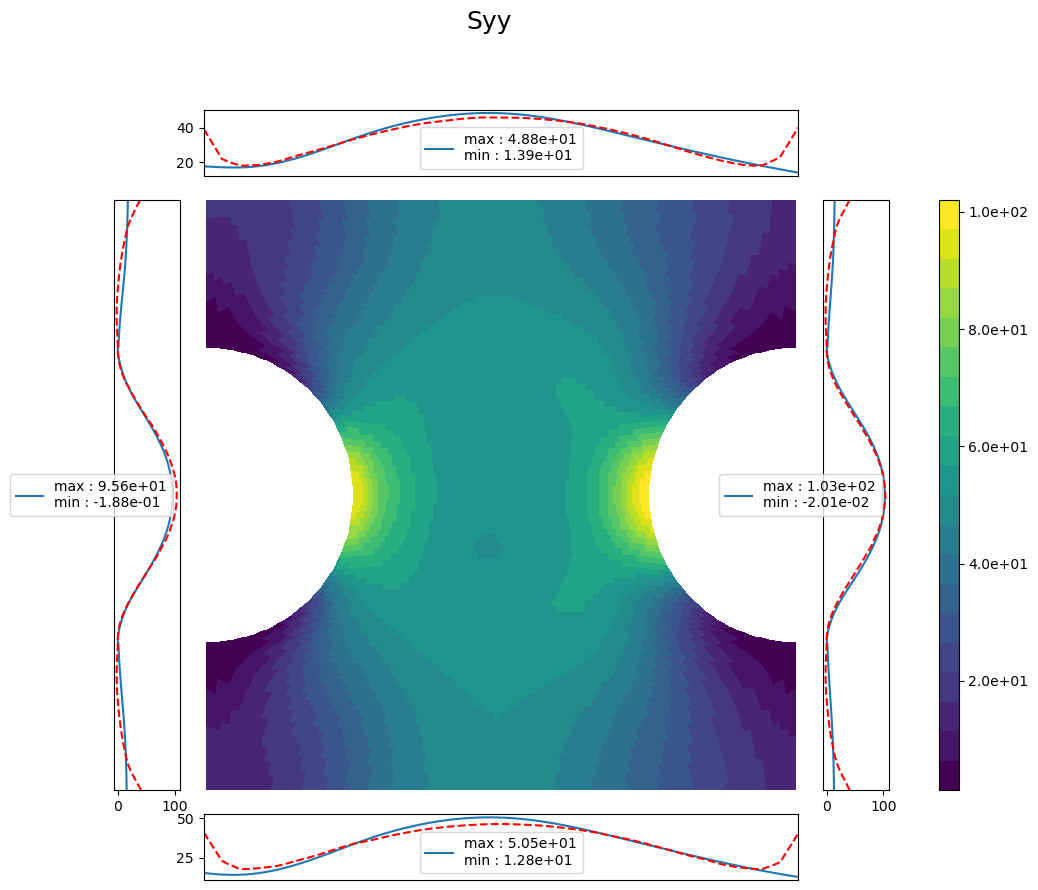

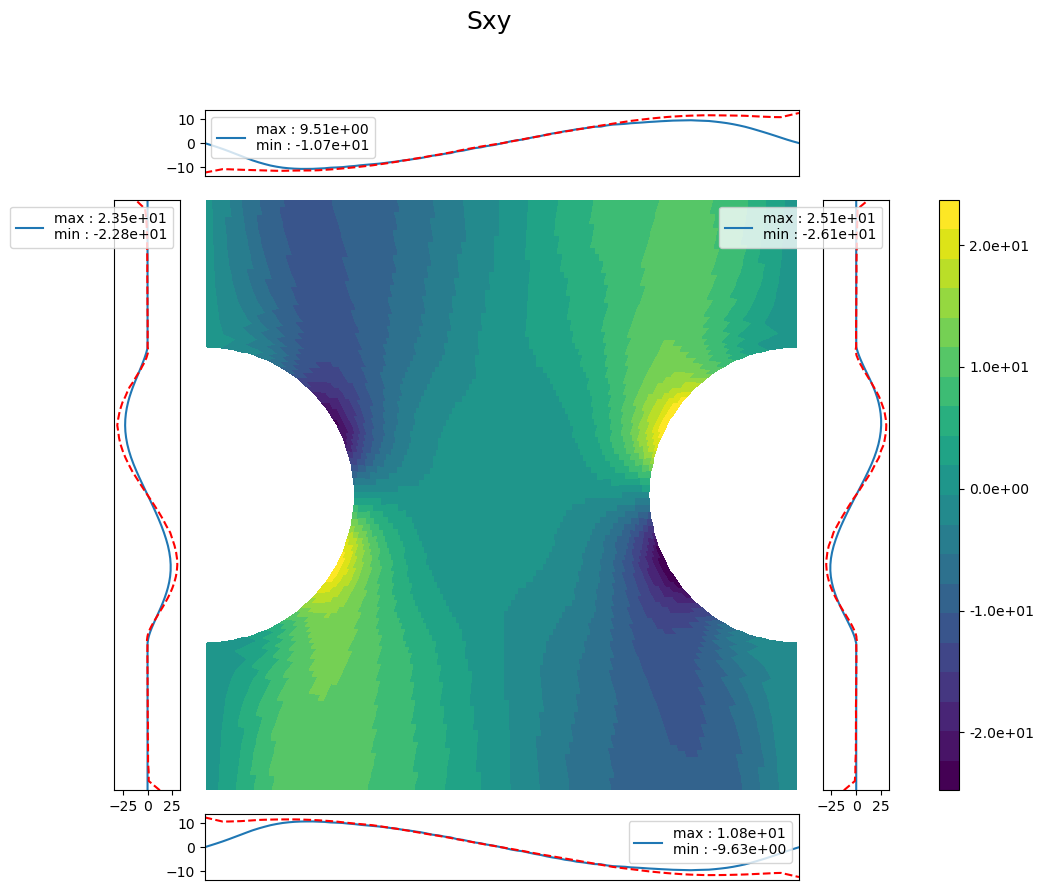

In [270]:

def plot_boundary(F, F_bc, F_true, X, Y, title, axs):
    x_top = X[:,-1]
    x_bottom = X[:,0]
    y_left = Y[0,:]
    y_right = Y[-1,:]

    F_top = F_bc[-1,:]
    F_bottom = F_bc[0,:]
    F_left = F_bc[:,0]
    F_right = F_bc[:,-1]

    x_bcs = [x_top, x_bottom, F_left, F_right] 
    y_bcs = [F_top, F_bottom, y_left, y_right]

    F_top_true = F_true[-1,:]
    F_bottom_true = F_true[0,:]
    F_left_true = F_true[:,0]
    F_right_true = F_true[:,-1]

    x_bcs_true = [x_top, x_bottom, F_left_true, F_right_true]
    y_bcs_true = [F_top_true, F_bottom_true, y_left, y_right]

    index_bcs = [[0,1],[2,1],[1,0],[1,2]]

    axs[0][0].axis("off")
    axs[0][2].axis("off")
    axs[2][0].axis("off")
    axs[2][2].axis("off")

    for i, (x_bc, y_bc, x_bc_true, y_bc_true, ind) in enumerate(zip(x_bcs, y_bcs, x_bcs_true, y_bcs_true, index_bcs)):
        # axs[ind[0]][ind[1]].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
        if i<2:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(y_bc):.2e}\nmin : {np.min(y_bc):.2e}")
            axs[ind[0]][ind[1]].plot(x_bc_true, y_bc_true, color='red', linestyle='--')
            axs[ind[0]][ind[1]].xaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_xlim([0, x_max])
            # axs[ind[0]][ind[1]].set_ylim([min(y_bc), max(y_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_yscale('log')

        else:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(x_bc):.2e}\nmin : {np.min(x_bc):.2e}")
            axs[ind[0]][ind[1]].plot(x_bc_true, y_bc_true, color='red', linestyle='--')

            axs[ind[0]][ind[1]].yaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_ylim([0, y_max])
            # axs[ind[0]][ind[1]].set_xlim([min(x_bc), max(x_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_xscale('log')
        axs[ind[0]][ind[1]].legend()
            
    im = pcolor_plot(axs[1][1], X, Y, F, None)
    axs[1][1].set_zorder(-1)
    pos = axs[1][2].get_position()
    cax = fig.add_axes([pos.width + pos.x0 +0.05, pos.y0, 0.02, pos.height])
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    plt.tight_layout()
    plt.suptitle(title, fontsize=18)


fields = [Ux, Uy, Sxx, Syy, Sxy]
fields_bc = [F_bcs[:,i].reshape(len(x_bcs), len(y_bcs)).T for i in range(5)]
# fields_bc_true = [solution_fn(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:, i].reshape(Xmesh.shape) for i in range(5)]
titles = ["Ux", "Uy", "Sxx", "Syy", "Sxy"]

for i,title in enumerate(titles):
    field = fields[i]
    field_bc = fields_bc[i]
    field_true = fields_bc_true[i].T
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
    plot_boundary(field, field_bc, field_true, Xmesh, Ymesh, title, axs)

# fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
# plot_boundary(Ux, Xmesh, Ymesh, "Ux", axs)



3262.7598872577846


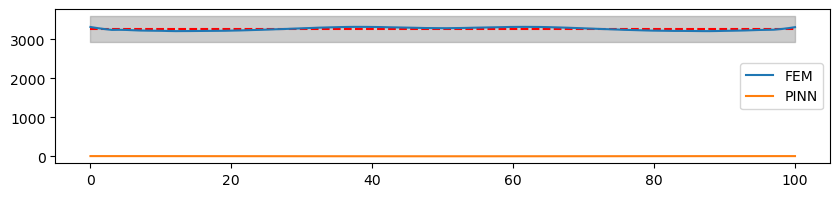

In [217]:
def integral_stress(inputs, outputs):
    if net_type == "spinn" and isinstance(inputs, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(inputs[0].squeeze()), 
            jnp.atleast_1d(inputs[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    x_mesh = jax.vmap(coordMap)(x)[:,0].reshape((inputs[0].shape[0], inputs[0].shape[0]))

    Syy = outputs[0][:, 3:4].reshape(x_mesh.shape)
    return jnp.trapezoid(Syy, x_mesh, axis=0)

n_integral = 100
x_integral = np.linspace(0, x_max, n_integral).reshape(-1, 1)
X_integral = [x_integral, x_integral]

S_yy_integral = model.predict(X_integral, operator=integral_stress)
S_yy_fem = solution_fn(X_integral)[:, 3:4].reshape(n_integral, n_integral)
x_integral_mesh = transform_coords(X_integral)
x_integral_mesh = jax.vmap(coordMap)(x_integral_mesh)[:,0].reshape(n_integral, n_integral)
S_yy_integral_fem = np.trapezoid(S_yy_fem, x_integral_mesh, axis=0)

x_width = x_integral_mesh[-1, :] - x_integral_mesh[0, :]
p_top = S_yy_integral_fem.mean()

# S_yy_integral_fem = np.mean(S_yy_fem, axis=0) * x_width
# 
# plt.figure(figsize=(4, 8))
# # plt.plot(S_yy_integral,x_integral, label="Integral stress Syy") 
# plt.plot(S_yy_integral_fem, x_integral, label="Integral stress Syy FEM", linestyle='--')
# plt.vlines(S_yy_integral_fem.mean(), 0, x_max, color='red', linestyle='--', label="x_max")

plt.figure(figsize=(10, 2))
plt.hlines(p_top, 0, y_max, color='red', linestyle='--')
plt.plot(x_integral,S_yy_integral_fem, label="FEM", linestyle='-')
plt.plot(x_integral,S_yy_integral, label="PINN", linestyle='-')
plt.legend()

# plt.plot(y_plot, x_width, label="x_max", linestyle='--', color='black')
plt.ylim(0.75*p_top, 1.25*p_top)  # Set the minimum and maximum y-axis values
plt.fill_betweenx([0.9*p_top, 1.1*p_top], 0, y_max, color='grey', alpha=0.4)
print(p_top)
# print(p_stress)

In [172]:
p_top = S_yy_integral_fem.mean()
print(f"p_top = {p_top:.4f} MPa")

p_top = 0.7416 MPa


Balance loss: 0.013016298
Balance loss check: 0.009062629
Balance loss FEM: 4.491922


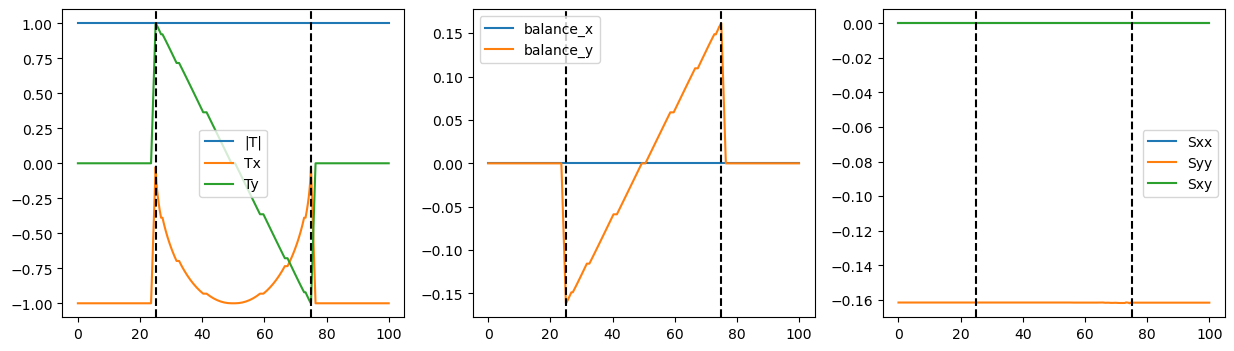

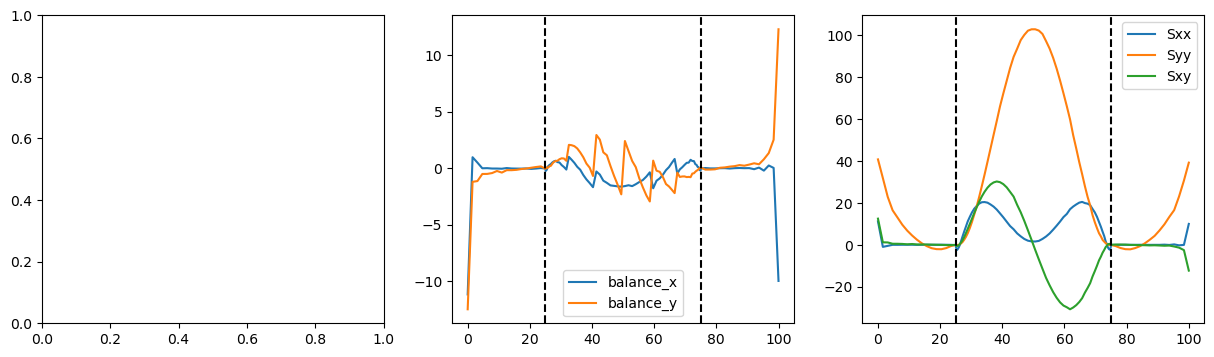

In [215]:
x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)

n_free = 400
y_free = jnp.linspace(0, x_max, n_free)
X_free = jnp.stack((jnp.zeros(n_free), y_free), axis=1)
sharp_corner_tol = 0.1

mask = (notch_dist < jax.vmap(coordMap)(X_free)[:, 1]) & (jax.vmap(coordMap)(X_free)[:, 1] < y_max- notch_dist)
X_free = X_free[mask] #keep middle height (deep notched) 

X_free_left = [jnp.array([0]).reshape(-1, 1), X_free[:, 1].reshape(-1, 1)]

X_left_mapped = jax.vmap(coordMap)(X_left)

# Tx = [-X_left_mapped[i,0]/R if X_left_mapped[i,1] <= R+1e-6 else -1 for i in range(ngrid)]
# Ty = [-X_left_mapped[i,1]/R if X_left_mapped[i,1] <= R+1e-6 else 0 for i in range(ngrid)] 

normal_mapped = jax.vmap(calcNormal)(X_left)
Tx_j, Ty_j = normal_mapped[:, 0], normal_mapped[:, 1]
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.quiver(X_left_mapped[:,0], X_left_mapped[:,1], Tx, Ty, scale=7)
# plt.quiver(X_left_mapped[:,0], X_left_mapped[:,1], Tx_j, Ty_j, scale=7, color='r')


# plt.scatter(X_left_mapped[:,0], X_left_mapped[:,1], c=Tx, cmap='viridis', s=1)
# plt.gca().set_aspect('equal', adjustable='box')
# ax.set_xlim([-0.2, 0.55])

# Tx, Ty = jnp.array(Tx), jnp.array(Ty)
Tx, Ty = Tx_j, Ty_j

inputs = [[jnp.array([0]).reshape(-1, 1), X_left[:, 1].reshape(-1, 1)]]
outputs = model.predict(inputs)

Sxx_left = outputs[:,2]
Syy_left = outputs[:,3]
Sxy_left = outputs[:,4]

# Sxx_left = fields_bc[2][:,0]
# Syy_left = fields_bc[3][:,0]
# Sxy_left = fields_bc[4][:,0]
# Sbc_left = fields_bc[5][:,0]

balance_x = Sxx_left*Tx + Sxy_left*Ty 
balance_y = Sxy_left*Tx + Syy_left*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(X_left_mapped[:,1],np.array(Tx)**2 + np.array(Ty)**2, label='|T|')
axs[0].plot(X_left_mapped[:,1],Tx, label='Tx')
axs[0].plot(X_left_mapped[:,1],Ty, label='Ty')
axs[0].axvline(notch_dist, color='black', linestyle='--')
axs[0].axvline(y_max - notch_dist, color='black', linestyle='--')
axs[0].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y, label='balance_y')
axs[1].axvline(notch_dist, color='black', linestyle='--')
axs[1].axvline(y_max - notch_dist, color='black', linestyle='--')
axs[1].legend()
# axs[1].set_ylim([-0.2, 0.2])
# axs[1].set_ylim([-0.05, 0.05])

axs[2].plot(X_left_mapped[:,1],Sxx_left, label='Sxx')
axs[2].plot(X_left_mapped[:,1],Syy_left, label='Syy')
axs[2].plot(X_left_mapped[:,1],Sxy_left, label='Sxy')
axs[2].axvline(notch_dist, color='black', linestyle='--')
axs[2].axvline(y_max - notch_dist, color='black', linestyle='--')
# axs[2].set_ylim([-0.3, 0.3])

# axs[2].plot(X_left_mapped[:,1],Sbc_left, label='Sbc')
axs[2].legend()


inputs = [X_free_left]
outputs = model.predict(inputs)
print("Balance loss:", np.mean(np.square(free_surface_balance(inputs[0], [outputs], X_left_mapped))))
y_mask = (y_left > notch_dist) & (y_left < y_max - notch_dist)
print("Balance loss check:", np.mean(np.square(np.abs(balance_x[y_mask]) + np.abs(balance_y[y_mask]))))


def solution_fn_flat(x):
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

F_left_exact = solution_fn_flat(np.stack((x_left, y_left), axis=1))

balance_x = F_left_exact[:,2]*Tx + F_left_exact[:,4]*Ty
balance_y = F_left_exact[:,4]*Tx + F_left_exact[:,3]*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[2].plot(X_left_mapped[:,1],F_left_exact[:,2], label='Sxx')
axs[2].plot(X_left_mapped[:,1],F_left_exact[:,3], label='Syy')
axs[2].plot(X_left_mapped[:,1],F_left_exact[:,4], label='Sxy')
axs[2].axvline(notch_dist, color='black', linestyle='--')
axs[2].axvline(y_max - notch_dist, color='black', linestyle='--')
# axs[2].set_ylim([-1, 1])
axs[2].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y, label='balance_y')
axs[1].axvline(notch_dist, color='black', linestyle='--')
axs[1].axvline(y_max - notch_dist, color='black', linestyle='--')
# axs[1].set_ylim([-0.2, 0.2])
axs[1].legend()



print("Balance loss FEM:", np.mean(np.square(np.abs(balance_x[y_mask]) + np.abs(balance_y[y_mask]))))

